# Spring 2024 6.8200 Computational Sensorimotor Learning Assignment 1
In this assignment, we will learn about multi-armed and contextual bandits.  You will need to <font color='blue'>answer the bolded questions</font> and <font color='blue'>fill in the missing code snippets (marked by **TODO**)</font>.

Make a copy of this notebook using File > Save a copy in Drive and edit it with your answers.

**IMPORTANT**: Set your runtime to GPU, otherwise the checkers may fail. Go to Runtime-> Change Runtime type -> Select T4 GPU.

**WARNING**: Do not put your name or any other personal identification information in this notebook.

There are 165 total points in this assignment, scaled to be worth 6.25% of your final grade.

### Setup

Run the following skeleton code (imports, plotting).

In [ ]:
!pip install git+https://github.com/Improbable-AI/sensorimotor_checker.git@master

  Cloning https://github.com/Improbable-AI/sensorimotor_checker.git (to revision master) to /tmp/pip-req-build-jqkxngug
  Running command git clone --filter=blob:none --quiet https://github.com/Improbable-AI/sensorimotor_checker.git /tmp/pip-req-build-jqkxngug
  Running command git checkout -b master --track origin/master
  Switched to a new branch 'master'
  Branch 'master' set up to track remote branch 'master' from 'origin'.
  Resolved https://github.com/Improbable-AI/sensorimotor_checker.git to commit e02f6303ebf14b5ed27a7b5aeed7e3a5427e22ff
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for sensorimotor_checker: filename=sensorimotor_checker-0.0.9-py3-none-any.whl size=4298 sha256=bb751c1469a7d3a5f4d2455270e91c0fc1c5a5f2b83ff5c0dbb9eca0bbff08af
  Stored in directory: /tmp/pip-ephem-wheel-cache-t9096963/wheels/50/00/f1/315b902a24192b47f94d124df94d7c064c98abe3c39c44d1a4
Successful

In [ ]:
%matplotlib inline
import numpy as np
import random
import time
import os
import gym
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd

import unittest
from copy import deepcopy
from tqdm.notebook import tqdm
from dataclasses import dataclass
from typing import Any
mpl.rcParams['figure.dpi']= 100

from sensorimotor_checker import hw1_tests

In [ ]:
# some util functions
def plot(logs, x_key, y_key, legend_key, **kwargs):
    nums = len(logs[legend_key].unique())
    palette = sns.color_palette("hls", nums)
    if 'palette' not in kwargs:
        kwargs['palette'] = palette
    ax = sns.lineplot(x=x_key, y=y_key, data=logs, hue=legend_key, **kwargs)
    return ax

def set_random_seed(seed):
    np.random.seed(seed)
    random.seed(seed)

# set random seed
seed = 0
set_random_seed(seed=seed)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Multi-armed bandits

Let us define a multi-armed bandit scenario with 10 arms.  There are two slightly different formulations that are useful:

- Stochastic Case: Each arm has a reward of 1, with probability $p \in [0, 1]$.
- Deterministic Case:  Each arm has a reward $r \in [0,1]$, but the same reward is obtained for every pull.


In this assignment, we will work through the stochastic case.  The same insights would apply to the deterministic scenario with variable rewards or even to stochastic setups with variable rewards.

To define our bandit, we arbitrarily select probabilities $p$ for each arm and save them as `probs`.



In [ ]:
numArms = 10
probs = [np.random.random() for i in range(numArms)]
print(probs)

[0.5488135039273248, 0.7151893663724195, 0.6027633760716439, 0.5448831829968969, 0.4236547993389047, 0.6458941130666561, 0.4375872112626925, 0.8917730007820798, 0.9636627605010293, 0.3834415188257777]


We then define an environment to evaluate different agent strategies.

In [ ]:
#To simulate a realistic Bandit scenario, we will make use of the BanditEnv.
@dataclass
class BanditEnv:
    probs: np.ndarray # probabilities of giving positive reward for each arm

    def step(self, action):
        # Pull arm and get stochastic reward (1 for success, 0 for failure)
        return 1 if (np.random.random()  < self.probs[action]) else 0

In [ ]:
#Code for running the bandit environment.
@dataclass
class BanditEngine:
    probs: np.ndarray
    max_steps: int
    agent: Any

    def __post_init__(self):
        self.env = BanditEnv(probs=self.probs)

    def run(self, n_runs=1):
        log = []
        for i in tqdm(range(n_runs), desc='Runs'):
            run_rewards = []
            run_actions = []
            self.agent.reset()
            for t in range(self.max_steps):
                action = self.agent.get_action()
                reward = self.env.step(action)
                self.agent.update_Q(action, reward)
                run_actions.append(action)
                run_rewards.append(reward)
            data = {'reward': run_rewards,
                    'action': run_actions,
                    'step': np.arange(len(run_rewards))}
            if hasattr(self.agent, 'epsilon'):
                data['epsilon'] = self.agent.epsilon
            run_log = pd.DataFrame(data)
            log.append(run_log)
        return log

In [ ]:
#Code for aggregrating results of running an agent in the bandit environment.
def bandit_sweep(agents, probs, labels, n_runs=2000, max_steps=500):
    logs = dict()
    pbar = tqdm(agents)
    for idx, agent in enumerate(pbar):
        pbar.set_description(f'Alg:{labels[idx]}')
        engine = BanditEngine(probs=probs, max_steps=max_steps, agent=agent)
        ep_log = engine.run(n_runs)
        ep_log = pd.concat(ep_log, ignore_index=True)
        ep_log['Alg'] = labels[idx]
        logs[f'{labels[idx]}'] = ep_log
    logs = pd.concat(logs, ignore_index=True)
    return logs


Credits: The code for Multi-Arm Bandits is inspired from

* https://github.com/ShangtongZhang/reinforcement-learning-an-introduction/blob/master/chapter02/ten_armed_testbed.py

* https://github.com/lilianweng/multi-armed-bandit/blob/master/solvers.py

## Oracle Agent

The best agent we could possibly build is one that has access to all the necessary information to make an optimal decision, even if that information would not be available in a real world problem.  We call this an "oracle agent."  

Imagine you were to build an Oracle agent for the stochastic multi-armed bandits problem defined by `probs`.  What reward would you get from this agent in expectation?

In [ ]:
#### TODO: find the maximum return with priviledged infromation about the reward distribution [5pts] ####

oracle_reward = np.amax(probs)
print('oracle_reward: ', oracle_reward)
##################################
suite = unittest.TestSuite()
suite.addTest(hw1_tests.TestOracleAgent('check_reward', oracle_reward))
unittest.TextTestRunner(verbosity=0).run(suite)

----------------------------------------------------------------------
Ran 1 test in 0.000s

OK


oracle_reward:  0.9636627605010293


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

## Random Agent

That's pretty high reward!  However, let's say that we don't have access to `probs`, and that the only information we can learn about the environment is through interaction.  This is more akin to a real world bandits problem.

One baseline agent we should construct is one that chooses a random action at every timestep.  Fill in the `TODO` in the below agent code to implement this behavior.

In [ ]:
#As a baseline, lets first construct a baseline agent that chooses a random action at every timestep.
#We will measure how much better we can do.
@dataclass
class RandomAgent:
    num_actions: int

    def __post_init__(self):
        self.reset()

    def reset(self):
        self.t = 0
        self.action_counts = np.zeros(self.num_actions, dtype=int) # action counts n(a)
        self.Q = np.zeros(self.num_actions, dtype=float) # action value Q(a)

    def update_Q(self, action, reward):
        pass

    def get_action(self):
        self.t += 1
        #### TODO: get a random action index [5pts]####

        selected_action = random.choice(range(self.num_actions))

        return selected_action

In [ ]:
#Create the random agent.
agent = RandomAgent(num_actions=len(probs))
'''
In order to measure average behavior of the agent, we are going to run the agent
multiple times and compute the mean reward. The number of runs will be denoted
by the variable `n_runs`. The default value is set to 1000, but feel free to reduce it
it if its taking too much time.
'''
n_runs = 1000
logs = bandit_sweep([agent], probs, ['Random'], n_runs=n_runs)

  0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Random Agent reward:  0.615614


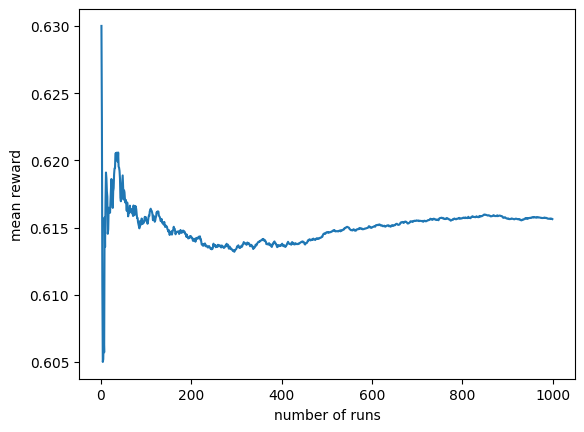

In [ ]:
#### TODO: plot the reward curve of a random agent, and print the average reward over this of this agent [5pts]####
mean_reward_tmp = [np.mean(logs['reward'][0:500*i]) for i in range(n_runs)]
plt.plot(range(n_runs), mean_reward_tmp)
plt.xlabel('number of runs')
plt.ylabel('mean reward')
###############################
mean_reward = np.mean(logs['reward'])
print('Random Agent reward: ', mean_reward)

In [ ]:
suite = unittest.TestSuite()
suite.addTest(hw1_tests.TestRandomAgent('check_performance', logs))
unittest.TextTestRunner(verbosity=0).run(suite)

----------------------------------------------------------------------
Ran 1 test in 0.002s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

**Analyzing the Results:**
- On the x-axis is the number of steps taken by the agent.
- On the y-axis is the average reward at step $i$.

The reward obtained by the random agent is far less that the oracle agent. Regret is defined as the difference between the the reward collected by oracle and the agent under consideration. In the above example, regret is about 0.35.

**Note:** that if you use a different random seed to run experiments, you might get a slighly different value of regret. Treat this as a ball park figure.

## Explore First Agent

In the class we discussed an algorithm to solve bandits where,
- Exploration Phase: For the first N (defined as `max_explore` in the code) steps the agent takes random actions to estimate the value of different arms.
- Exploitation Phase: In each step after that, the agent identifies the best arm based on the information it aggregated so far.
Notice that the agent keeps updating its prediction even after the inital N steps.

We will now implement this agent below.  Fill in the missing code in `update_Q` and `get_action`.  We will store the average reward for each action in the variable `self.Q` (see slide 43 in Lec 2 slides), and the count of how many times we've taken each action in `self.action_counts`.

In [ ]:
#Lets now construct the explore first agent
@dataclass
class ExploreFirstAgent:
    num_actions: int
    max_explore: int

    def __post_init__(self):
        self.reset()

    def reset(self):
        self.t = 0
        self.action_counts = np.zeros(self.num_actions, dtype=int) # action counts n(a)
        self.Q = np.zeros(self.num_actions, dtype=float) # action value Q(a)

    def update_Q(self, action, reward):
        # Update Q action-value given (action, reward)
        # HINT: Keep track of how good each arm is
        #### TODO: update Q value [5pts] ####

        self.action_counts[action] += 1
        self.Q[action] = (self.Q[action]*(self.action_counts[action]-1) + reward)/self.action_counts[action]
        ##################################

    def get_action(self):
        self.t += 1
        #### TODO: get action [5pts] ####
        if self.t > self.max_explore:
            selected_action = np.argmax(self.Q)
        else:
            selected_action = random.choice(range(self.num_actions))
        ##################################

        return selected_action

Great! Now we'll instantiate the engine, and run it with $N=5$ (five steps of exploration, followed by entirely greedy policy).

  0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


<Axes: xlabel='step', ylabel='reward'>

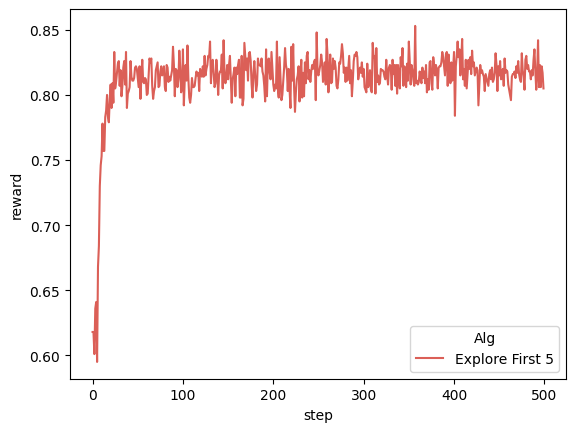

In [ ]:
max_explore = 5
agent = ExploreFirstAgent(num_actions=len(probs), max_explore=max_explore)
logs = bandit_sweep([agent], probs, ['Explore First 5'], n_runs=1000, max_steps=500)
plot(logs, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', errorbar=None)

#### Check your work:
If you pass update_Q but fail in performance, check your get action and ensure that you're on GPU runtime.

In [ ]:
suite = unittest.TestSuite()
suite.addTest(hw1_tests.TestExploreFirstAgent('check_update_Q', ExploreFirstAgent))
suite.addTest(hw1_tests.TestExploreFirstAgent('check_performance', logs))
unittest.TextTestRunner(verbosity=0).run(suite)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
----------------------------------------------------------------------
Ran 2 tests in 0.002s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

### Explore First v.s. Random Agent


The results clearly show that the explore first agent performs better than the random agent. However, it still performs much worse than the oracle. How can we improve our performance?

If there are 10 possible actions but the agent only explores for 5 steps, then it is likely it won't find the best arm.  Thus, the policy will be suboptimal. Let's see what happens when we allow the agent to explore for more steps.


In [ ]:
['Explore First {}'.format(max_explore) for _, max_explore in enumerate(max_explore_steps)]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['Explore First 5',
 'Explore First 10',
 'Explore First 50',
 'Explore First 100',
 'Explore First 200']

  0%|          | 0/5 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

<Axes: xlabel='step', ylabel='reward'>

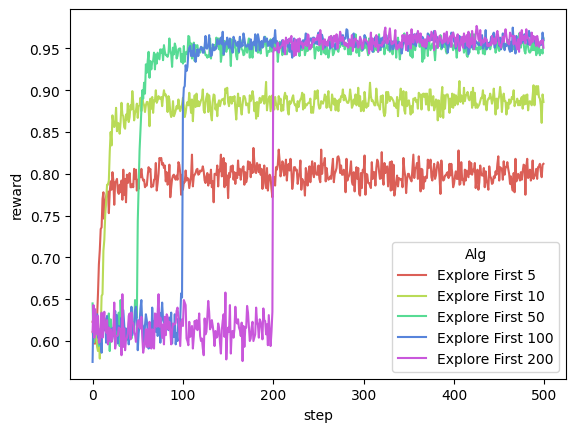

In [ ]:
'''
What happens if we allow the agent to explore for only 5, 10, 50, 100, 200 steps respectively?
'''
max_explore_steps = [5, 10, 50, 100, 200]
n_runs = 1000
#### TODO: run ExploreFirstAgent with different max_explore steps, and plot the reward curves [10pts]####
agents = []
for i, max_explore in enumerate(max_explore_steps):
    agents.append( ExploreFirstAgent(num_actions=len(probs), max_explore=max_explore) )

logs = bandit_sweep(agents, probs, labels=['Explore First {}'.format(max_explore) for _, max_explore in enumerate(max_explore_steps)], n_runs=1000, max_steps=500)
plot(logs, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', errorbar=None)
#########################################

**Analyzing the Results**

- Notice that for all agents there is a jump in performance. This corresponds to the time point when they switch from explore only to exploit mode.

- The agents that explore for 5, 10 steps are unable to accurately identify the best arm everytime. Their scores are lower than that of agents exploring for 50 or 100 steps. These agents find the optimal arm.

**Moving to More Realistic Scenarios**

**Question (5pts)**:
It's unclear how long the agent should explore before switching to exploit mode.  Can you come up with a strategy to choose a good value of `max_explore`? Can we use such a strategy to deploy a product?

**Answer**: Above result indicates that there is no advantage of increasing the maximum explore above 50. Therefore, a good value is 50 in this case. However in general, it will highly depend on the problem. We can check the several max_explore values as in this problem, but it will be very inefficient as the problem scales


## UCB Agent

Rather than having seperate exploration and exploitation phases, an agent should be able to figure out when to explore and when to exploit.  This leads us to the UCB agent that we discussed in class.

Implement the `update_Q` and `get_action` methods for a UCB agent using the course notes.

In [ ]:
#### UCB Agent ####
@dataclass
class UCBAgent:
    num_actions: int

    def __post_init__(self):
        self.reset()

    def reset(self):
        self.t = 0
        self.action_counts = np.zeros(self.num_actions, dtype=int) # action counts n(a)
        self.Q = np.zeros(self.num_actions, dtype=float) # action value Q(a)

    def update_Q(self, action, reward):
        # Update Q action-value given (action, reward)
        #### TODO: Calculate the Q-value [5pts] ####
        self.action_counts[action] += 1
        self.Q[action] = (self.Q[action]*(self.action_counts[action]-1) + reward)/self.action_counts[action]
        ###############################

    def get_bonus(self, t, action_counts):
        #### TODO: Calculate the exploration bonus. To avoid a division by zero, add a small delta=1e-5 to the denominator [5pts] ####
        return np.sqrt(4*np.log(t)/(action_counts + 1e-5))
        ###############################

    def get_action(self):
        self.t += 1
        Q_explore = self.Q + self.get_bonus(self.t, self.action_counts)
        return np.random.choice(np.where(Q_explore == Q_explore.max())[0])

  0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


<Axes: xlabel='step', ylabel='reward'>

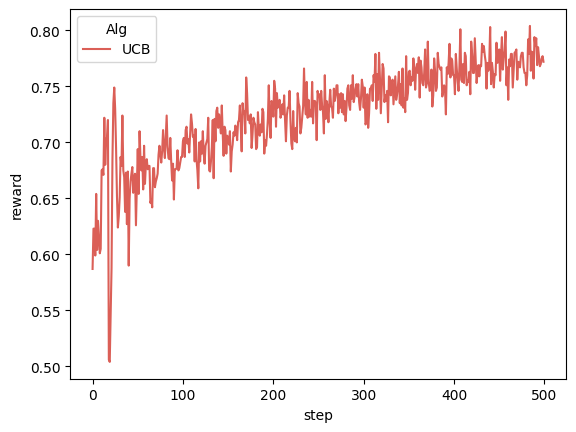

In [ ]:
#Define the UCB Agent
agentUCB = UCBAgent(num_actions=len(probs))
#Compute Performance
logs = bandit_sweep([agentUCB], probs, ['UCB'], n_runs=1000, max_steps=500)
#Plot Performance
plot(logs, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', errorbar=None)

#### Check your work:
If all other tests pass but check_performance fails, make sure your runtime type is GPU and then come to OH or post on piazza.

In [ ]:
suite = unittest.TestSuite()
suite.addTest(hw1_tests.TestUCBAgent('check_update_Q', UCBAgent))
suite.addTest(hw1_tests.TestUCBAgent('check_exploration_bonus', UCBAgent))
suite.addTest(hw1_tests.TestUCBAgent('check_performance', logs))

unittest.TextTestRunner(verbosity=0).run(suite)

----------------------------------------------------------------------
Ran 3 tests in 0.003s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

### UCB v/s Explore-First

Now let's compare the reward curves of the `UCB` agent and `Explore First` agent with `max_explore=5`.

**Analyzing the Results**

**Question [5pts]**: Why does the UCB algorithm learn slowly (even after 500 steps, the agent still does not reach the maximum reward)?

**Answer**: Because the magnitude of bonus might not large enough. Therefore it needs a lot of steps to get sufficient explorations.  


  0%|          | 0/2 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

<Axes: xlabel='step', ylabel='reward'>

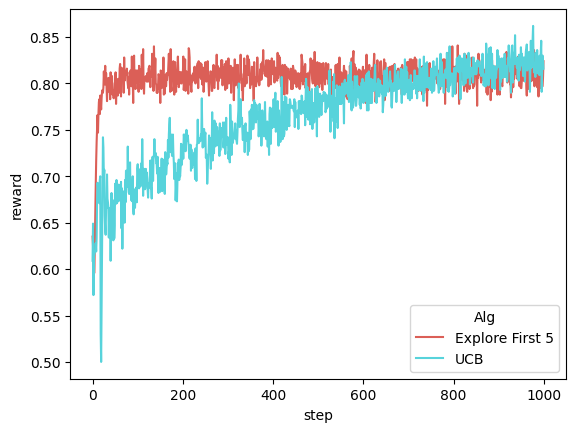

In [ ]:
#Now we will compare the UCB agent against the ExploreFirst Agent that only explores for 5 steps.
#### TODO: run both algorithms and plot the reward curves (max_explore=5) [10pts] ####
#### use legends ['UCB', 'Explore First 5'] respectively
#### run each algorithm 1000 times (n_runs=1000), and max_steps=1000
max_explore = 5
agent_EF = ExploreFirstAgent(num_actions=len(probs), max_explore=max_explore)
agent_UCB = UCBAgent(num_actions=len(probs))

logs = bandit_sweep([agent_EF, agent_UCB], probs, ['Explore First 5', 'UCB'], n_runs=1000, max_steps=1000)
plot(logs, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', errorbar=None)
##################################

**Result Analysis:** UCB outperforms the greedy Explore First agent that only explores for 5 steps.

What happens if we allow the agent to explore for more steps?  Run the Explore First agent for 20 steps, and compare the reward to the UCB agent.

  0%|          | 0/2 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

<Axes: xlabel='step', ylabel='reward'>

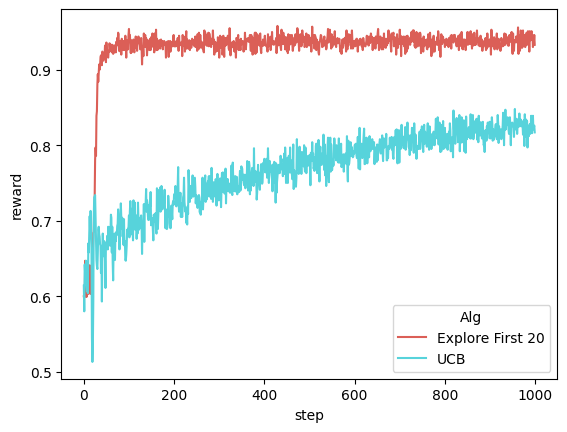

In [ ]:
#Lets compare UCB with an agent that explores for twenty steps.
#### TODO: run both algorithms and plot the reward curves (max_explore=20) [10pts] ####
#### use legends ['UCB', 'Explore First 20'] respectively
#### run each algorithm 1000 times (n_runs=1000), and max_steps=1000
max_explore = 20
agent_EF = ExploreFirstAgent(num_actions=len(probs), max_explore=max_explore)
agent_UCB = UCBAgent(num_actions=len(probs))

logs = bandit_sweep([agent_EF, agent_UCB], probs, ['Explore First 20', 'UCB'], n_runs=1000, max_steps=1000)
plot(logs, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', errorbar=None)
##################################

**Question (5pts)**: In the lecture we studied that the UCB algorithm is optimal. Why then does Explore First perform better?

**Answer**:
1. UCB can achieve the same guarantee as the ETC, but this does not mean that UCB can always outperform ETC. Furthermore, we can see from the above example that 20 is actually a pretty good number in this algorithm. If we did not know this prior knowledge, ETC might not outperform UCB

2. If we increase the step size, UCB can eventually reach the performance of ETC.

### Skewed Arms Scenario:

In the previous example, the probability of each arm providing a return was sampled uniformly from $[0,1]$. Because there were only 10 arms, and some arms had similar returns, by performing 20 random actions it is possible to find the best arm by chance. However, if the reward distributions are very skewed (e.g., only one arm returns rewards with high probability, say 0.9), or there are more arms, more actions may be necessary. In this case the initial exploration phase may not succeed at finding the best arm. Lets see this in practice below.

  0%|          | 0/2 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

<Axes: xlabel='step', ylabel='reward'>

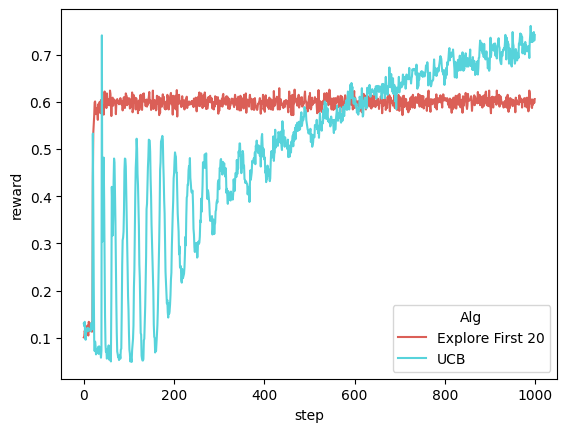

In [ ]:
skewedProbs = [0.1, 0.2, 0.15, 0.21, 0.3, 0.05, 0.9, 0.13, 0.17, 0.07, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
#### TODO: compare the reward curves of UCBAgent and ExploreFirstAgent (max_explore=len(skewedProbs)) [10pts] ####
#### sweep with n_runs=1000, max_steps=1000
max_explore = 20
agent_EF = ExploreFirstAgent(num_actions=len(skewedProbs), max_explore=max_explore)
agent_UCB = UCBAgent(num_actions=len(skewedProbs))

logs = bandit_sweep([agent_EF, agent_UCB], skewedProbs, ['Explore First 20', 'UCB'], n_runs=1000, max_steps=1000)
plot(logs, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', errorbar=None)
###################################

In this case, UCB performs better than *Explore First (20)*. It is because exploring for 20 steps is insufficient for this problem. This problem again illustrates that unless one has access to privileged information about the problem, UCB performs the best!

Also notice that UCB's reward is still increasing and it hasn't converged to the optimal action yet. Try varying the maximum number of steps to see when UCB converges to the optimal / oracle policy.

In other words, `max_explore` is a hyperparameter in the explore-first algorithm. Without "tuning" it, the method may perform well on some problem instances and poorly on others. An advantage of UCB is its lack of hyperparameters. Next, we'll consider another hyperparameter, $\epsilon$.

## Epsilon-greedy Agent

Another popular method of simultaneoulsy exploring/exploiting is $\epsilon$-greedy exploration. The main idea is to:
- Sample the (estimated) best action with probability $1-\epsilon$
- Perform a random action with probability $\epsilon$

By changing $\epsilon$, we can control if the agent is conservative or exploratory. We will now implement this agent.

In [ ]:
##EpsilonGreedy Agent
@dataclass
class EpsilonGreedyAgent:
    num_actions: int
    epsilon: float = 0.1

    def __post_init__(self):
        self.reset()

    def reset(self):
        self.action_counts = np.zeros(self.num_actions, dtype=int) # action counts n(a)
        self.Q = np.zeros(self.num_actions, dtype=float) # action value Q(a)

    def update_Q(self, action, reward):
        # Update Q action-value given (action, reward)
        self.action_counts[action] += 1
        self.Q[action] += (1.0 / self.action_counts[action]) * (reward - self.Q[action])

    def get_action(self):
        # Epsilon-greedy policy
        #### TODO: Code for exploration [5pts] ####
        if (np.random.random() <= self.epsilon) :
            selected_action = random.choice(range(self.num_actions))
        ###########################################
        #### TODO: Code for exploitation [5pts] ####
        else:
            # selected_action = np.argmax(self.Q)
            selected_action = np.random.choice(np.where(self.Q == self.Q.max())[0])
        ###########################################
        return selected_action

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


<Axes: xlabel='step', ylabel='reward'>

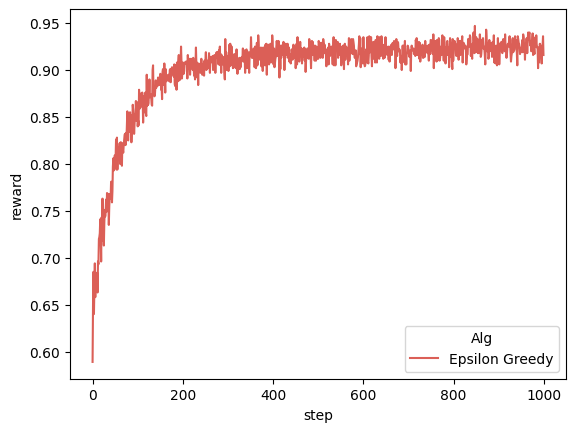

In [ ]:
agent = EpsilonGreedyAgent(num_actions=len(probs), epsilon = 0.1)
logs = bandit_sweep([agent], probs, ['Epsilon Greedy'], n_runs=1000, max_steps=1000)
plot(logs, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', errorbar=None)

In [ ]:
suite = unittest.TestSuite()
suite.addTest(hw1_tests.TestEpsilonGreedyAgent('check_performance', logs))
unittest.TextTestRunner(verbosity=0).run(suite)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
----------------------------------------------------------------------
Ran 1 test in 0.003s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

  0%|          | 0/4 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


<Axes: xlabel='step', ylabel='reward'>

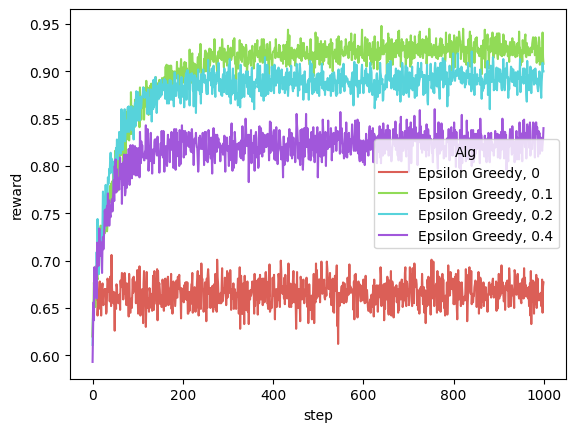

In [ ]:
#### TODO: show reward curves of an EpsilonGreedyAgent with epsilon=[0, 0.1, 0.2, 0.4] [10pts]####
epsilons=[0, 0.1, 0.2, 0.4]
agents = []
for i, epsilon in enumerate(epsilons):
    agents.append( EpsilonGreedyAgent(num_actions=len(probs), epsilon = epsilon) )

logs = bandit_sweep(agents, probs, labels=['Epsilon Greedy, {}'.format(epsilon) for epsilon in epsilons], n_runs=1000, max_steps=1000)
plot(logs, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', errorbar=None)
###########################################

**Analyzing Epsilon-Greedy Agents**

Notice that the reward of all agents gradually increases (except for $\epsilon=0$, which is an extremely greedy agent). Also, notice that reward is maxmium for $\epsilon=0.1$ but decreases for higher values.

**Question [5pts]**: Why is the reward lower for higher-values of $\epsilon$?

**Answer**: Because once we have enough exploration to find optimal action, it would be better to stick to that action rather than explore more


**Question [5pts]**: To overcome the issue above, one can try setting $\epsilon=0$ after some time or adaptively chaning $\epsilon$. Can you suggest a strategy for varying $\epsilon$ with time $T$?

**Answer**: We can set a weighting factor or substract a certain value after each step for epsilon, such as $\epsilon = \max{\{\epsilon_0-\lambda t, 0\}}$. In this case, as time grows, the probability to explore decreases

# Contextual bandits

In this section, we will deal with contextual bandits problem. In contextual bandits, we use contextual information about the observed subject to make subject-specific decisions.  The algorithm we will implement is called [LinUCB](https://arxiv.org/pdf/1003.0146.pdf).

As an example, imagine we have a website with 10 products that we'd like to promote. Whenever a user enters the website, the website promotes one product to the user. If the user clicks the product link, then it's a successful promotion (reward is $1$). Otherwise, it's a failed promotion (reward is $0$). Our goal is to optimize the click through rate (CTR), and thus optimize our $$$.

We will use a dataset from [here](http://www.cs.columbia.edu/~jebara/6998/dataset.txt) to explore contextual bandits.  The dataset contains a pre-logged array of shape $[10000, 102]$. Each row represents a data point at time step $t$ where $t\in[0, 9999]$. The first column represents the index of the arm $a_t$ that's chosen ($10$ arms in total). The second column represents the reward $r_t\in\{0,1\}$ received for taking the selected arm. The last $100$ columns represent the context feature vector.

The following code is inspired by [this code repository](https://github.com/kfoofw/bandit_simulations).

In [ ]:
# Download the dataset
!wget http://www.cs.columbia.edu/~jebara/6998/dataset.txt

--2024-02-18 04:06:44--  http://www.cs.columbia.edu/~jebara/6998/dataset.txt
Resolving www.cs.columbia.edu (www.cs.columbia.edu)... 128.59.11.206
Connecting to www.cs.columbia.edu (www.cs.columbia.edu)|128.59.11.206|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2149159 (2.0M) [text/plain]
Saving to: ‘dataset.txt.1’

dataset.txt.1       100%[===================>]   2.05M  1.62MB/s    in 1.3s    

2024-02-18 04:06:46 (1.62 MB/s) - ‘dataset.txt.1’ saved [2149159/2149159]



In [ ]:
# load in the dataset
data = pd.read_csv('dataset.txt', sep=" ", header=None)
data = data.iloc[:, :-1]
print(f'Dataset shape:{data.shape}')
data[0] -= 1 # we use 0-based numbering
data = data.to_numpy()

Dataset shape:(10000, 102)


In [ ]:
#### Contextual bandit environment ####
@dataclass
class ContextualBanditEnv:
    dataset: Any
    t: int = 0

    def step(self, action):
        # if the action matches the recorded action in the dataset, it will
        # return the recorded reward in the dataset. Otherwise, it will return
        # a reward of None
        if action == self.dataset[self.t, 0]:
            reward = self.dataset[self.t, 1]
        else:
            reward = None
        self.t += 1
        return reward

    def reset(self):
        self.t = 0

Fill in the missing code below to implement the LinUCB agent.

In [ ]:
#### LinUCB Agent ####
@dataclass
class LinUCBAgent:
    num_actions: int
    alpha: float
    feature_dim: int

    def __post_init__(self):
        self.reset()

    def reset(self):
        self.As = [np.identity(self.feature_dim) for i in range(self.num_actions)]
        self.bs = [np.zeros([self.feature_dim, 1]) for i in range(self.num_actions)]

    def get_ucb(self, action, state):
        #### TODO: compute the UCB of the selected action/arm, and the context information [5pts] ####
        state = state.reshape(len(state), 1)
        theta_a = np.linalg.inv(self.As[action]) @ self.bs[action]
        p_ta = theta_a.transpose()@state + self.alpha*np.sqrt(state.transpose() @ np.linalg.inv(self.As[action]) @ state)
        return p_ta
        ###########################################

    def update_params(self, action, reward, state):
        #### update A matrix and b matrix given the observed reward, ####
        #### selected action, and the context feature                ####
        if reward is None:
            return
        #### TODO: update A and b matrices of the selected arm [5pts] ####
        state = state.reshape(len(state), 1)
        self.As[action] = self.As[action] + state@state.transpose()
        self.bs[action] = self.bs[action] + reward*state
        ###########################################

    def get_action(self, state):
        #### find the action given the context information (a 1D state vecotr) ####

        arms_ucb = np.zeros(self.num_actions)
        for arm_id in range(self.num_actions):
            arm_ucb = self.get_ucb(arm_id, state)[0][0]
            arms_ucb[arm_id] = arm_ucb

        #### TODO: choose an arm a_t=\arg\max_a(p_{t,a}) with ties broken randomly [5pts] ####
        selected_action = np.random.choice(np.where(arms_ucb == arms_ucb.max())[0])
        ###########################################

        return selected_action


In [ ]:
#Code for running the contextual bandit environment.
@dataclass
class CtxBanditEngine:
    dataset: Any
    agent: Any

    def __post_init__(self):
        self.env = ContextualBanditEnv(dataset=self.dataset)

    def run(self, n_runs=1):
        log = []
        for i in tqdm(range(n_runs), desc='Runs'):
            # we only record the time steps when the selected arm matches the arm in the pre-logged data
            aligned_ctr = []
            ret_val = 0
            valid_time_steps = 0
            self.env.reset()
            self.agent.reset()
            for t in tqdm(range(self.dataset.shape[0]), desc='Time'):
                state=self.dataset[t, 2:]
                action = self.agent.get_action(state=state)
                reward = self.env.step(action)
                self.agent.update_params(action, reward, state=state)
                if reward is not None:
                    ret_val += reward
                    valid_time_steps += 1
                    aligned_ctr.append(ret_val / float(valid_time_steps))
            data = {'aligned_ctr': aligned_ctr,
                    'step': np.arange(len(aligned_ctr))}
            if hasattr(self.agent, 'alpha'):
                data['alpha'] = self.agent.alpha
            run_log = pd.DataFrame(data)
            log.append(run_log)
        return log

In [ ]:
#Code for aggregrating results of running an agent in the contextual bandit environment.
def ctxbandit_sweep(alphas, dataset, n_runs=2000):
    logs = dict()
    pbar = tqdm(alphas)
    for idx, alpha in enumerate(pbar):
        pbar.set_description(f'alpha:{alpha}')
        agent = LinUCBAgent(num_actions=10, feature_dim=100, alpha=alpha)
        engine = CtxBanditEngine(dataset=dataset, agent=agent)
        ep_log = engine.run(n_runs)
        ep_log = pd.concat(ep_log, ignore_index=True)
        ep_log['alpha'] = alpha
        logs[f'{alpha}'] = ep_log
    logs = pd.concat(logs, ignore_index=True)
    return logs

In [ ]:
# Run the sweep with alpha = [0, 0.01, 0.1, 0.5] and n_runs=1
logs = ctxbandit_sweep([0., 0.01, 0.1, 0.5], data, n_runs=1)

  0%|          | 0/4 [00:00<?, ?it/s]

Runs:   0%|          | 0/1 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

Runs:   0%|          | 0/1 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

Runs:   0%|          | 0/1 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

Runs:   0%|          | 0/1 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


<Axes: xlabel='step', ylabel='aligned_ctr'>

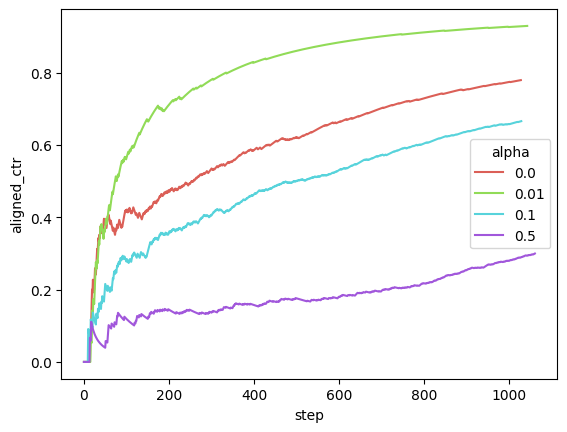

In [ ]:
plot(logs, x_key='step', y_key='aligned_ctr', legend_key='alpha', estimator='mean', errorbar=None)

#### Check your work:

In [ ]:
suite = unittest.TestSuite()
suite.addTest(hw1_tests.TestLinUCBAgent('check_get_ucb', LinUCBAgent))
suite.addTest(hw1_tests.TestLinUCBAgent('check_update_params', LinUCBAgent))
suite.addTest(hw1_tests.TestLinUCBAgent('check_logs', logs))
unittest.TextTestRunner(verbosity=0).run(suite)

----------------------------------------------------------------------
Ran 3 tests in 0.004s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

**Question [5pts]**: What does $\alpha$ affect in LinUCB?

**Answer**: $\alpha$ is a hyper parameter that defines the degree of bonus in LinUCB. If we set alpha large, the algorithm will explore more

**Question [5pts]**: Do the reward curves change with $\alpha$? If yes, why? If not, why not?

**Answer**: They do. This is because alpha corresponds to the degree of exploration.

Finally, let's compare LinUCB to UCB. We want to use the UCB algorithm while ignoring the context. Make a class that modifies the UCB agent which has the same methods as the LinUCB agent called ModUCBAgent. Notice that unlike the LinUCB agent this agent get the context as input but does not use it. Compare the ModUCBAgent to LinUCBAgent with alpha = 0, 0.01, 0.5.

In [ ]:
@dataclass
class ModUCBAgent:
    num_actions: int

    def __post_init__(self):
        self.reset()

    #### TODO: Implement the necessary function for a UCB agent. This agent should get the context vector but doesn't use it
    def reset(self):
        self.t = 0
        self.action_counts = np.zeros(self.num_actions, dtype=int) # action counts n(a)
        self.Q = np.zeros(self.num_actions, dtype=float) # action value Q(a)

    def update_params(self, action, reward, state):
        # Update Q action-value given (action, reward)
        if reward is None:
            return

        self.action_counts[action] += 1
        self.Q[action] = (self.Q[action]*(self.action_counts[action]-1) + reward)/self.action_counts[action]

    def get_action(self, state):
        self.t += 1
        Q_explore = self.Q + np.sqrt(4*np.log(self.t)/(self.action_counts + 1e-5))
        return np.random.choice(np.where(Q_explore == Q_explore.max())[0])
    ###########################################

def ctx_bandit_sweep(agents, labels, dataset, n_runs=2000):
    logs = dict()
    pbar = tqdm(agents)
    for idx, agent in enumerate(pbar):
        pbar.set_description(f'agent:{labels[idx]}')
        engine = CtxBanditEngine(dataset=dataset, agent=agent)
        ep_log = engine.run(n_runs)
        ep_log = pd.concat(ep_log, ignore_index=True)
        ep_log['agent'] = labels[idx]
        logs[f'{labels[idx]}'] = ep_log
    logs = pd.concat(logs, ignore_index=True)
    return logs

agents = [ModUCBAgent(num_actions=10)]
labels = ['ModUCB']
for alpha in [0, 0.01, 0.5]:
    agents.append(LinUCBAgent(num_actions=10, feature_dim=100, alpha=alpha))
    labels.append(f'LinUCB_{alpha}')
logs = ctx_bandit_sweep(agents, labels, data, n_runs=1)

  0%|          | 0/4 [00:00<?, ?it/s]

Runs:   0%|          | 0/1 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

Runs:   0%|          | 0/1 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

Runs:   0%|          | 0/1 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

Runs:   0%|          | 0/1 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated

<Axes: xlabel='step', ylabel='aligned_ctr'>

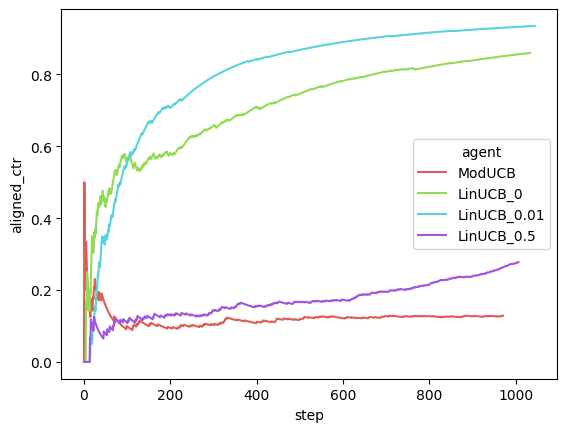

In [ ]:
plot(logs, x_key='step', y_key='aligned_ctr', legend_key='agent', estimator='mean', errorbar=None)

**Question [20pts]**: Does LinUCB outperform UCB? If yes, explain why. If not,
explain why not.

**Answer**: Yes, LinUCB outperforms UCB. This is because it modifies the action based on the additional information, the context.

**Survey [BONUS 10pts] Enter the bonus word you get after the survey.**

https://forms.gle/xypvUDsxmQiTEeWy6